In [1]:
import time
import json
from functools import wraps
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

import vk
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd

import numpy as np
from numpy.linalg import norm

from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

In [2]:
cache_filename = 'graph_vertex_cache.json'

In [3]:
with open("author.txt") as f:
    login = f.readline().rstrip()
    passwd = f.readline().rstrip()

session = vk.AuthSession(app_id='6070120', user_login=login, user_password=passwd)

api = vk.API(session)
api_version = "5.73"


requests_count = 0

## Load graph cache dictionary from file if possible

In [4]:
try:
    cache_dict = json.load(open(cache_filename, 'r'))
except FileNotFoundError:
    cache_dict = {}
    
cache_dict = {int(k): val for k, val in cache_dict.items()}

## Construct a graph

#### Necessary decorators

In [5]:
# decorator that handles sleeping
def vk_requester(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        global requests_count
        if requests_count == 3:
            requests_count = 0
            time.sleep(1)
        try:
            requests_count += 1
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code in (6, 10): # too many requests per second or internal server error
                time.sleep(1)
                requests_count += 1
                return_val = request_func(*args, **kwargs)
            else:
                raise err
        return return_val
    return wrapper

In [6]:
def request_list(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        return_val = request_func(*args, **kwargs)
        if isinstance(return_val, list):
            return return_val
        else:
            return list(return_val['items'])
    return wrapper

def handle_friends_exceptions(request_func):
    @wraps(request_func)
    def wrapper(*args, **kwargs):
        try:
            return_val = request_func(*args, **kwargs)
        except vk.exceptions.VkAPIError as err:
            if err.code == 18: # deleted or banned user
                return_val = []
            else:
                raise err
        return return_val
    return wrapper

In [7]:
@request_list
@handle_friends_exceptions
@vk_requester
def get_friends(api, api_version, user_id):
    return api.friends.get(user_id=user_id, v=api_version)

#### Custom `Graph` wrapper for `nx.Graph`

In [48]:
class Graph(nx.Graph):    
    def __init__(self, start_id, waves, *args, **kwargs):
        super(Graph, self).__init__(*args, **kwargs)
        self.start_id = start_id
        self.waves = waves
        self.nodes_waves = {wave: [] for wave in range(waves)}
        self.nodes_waves[waves] = [start_id]

    def reverse_waves(self):
        self.nodes_waves = {self.waves - key: val for key, val in self.nodes_waves.items()}

#### Functions responsible for graph construction

In [66]:
def construct_graph(user_id, output_graph, wave=3):
    output_graph.add_node(user_id)
    
    global cache_dict

    if user_id in cache_dict:
        friends = cache_dict[user_id]
    else:
        #print("{} not found in cache".format(user_id))
        friends = get_friends(api, api_version, user_id)
        cache_dict[user_id] = friends

    # add each friendship and dive deeper
    for friend in friends:
        friend_in_graph = friend in output_graph
        if wave != 0 and not friend_in_graph:
            output_graph.nodes_waves[wave - 1].append(friend)
            construct_graph(friend, output_graph, api, wave - 1)
        if wave == 0 and not friend_in_graph:
            continue

        output_graph.add_edge(user_id, friend)
        
        
def construct_graph_from_cache(user_id, output_graph, wave=3):
    output_graph.add_node(user_id)
    
    if user_id in cache_dict:
        friends = cache_dict[user_id]
        for friend in friends:
            friend_in_graph = friend in output_graph
            if wave != 0 and not friend_in_graph:
                output_graph.nodes_waves[wave - 1].append(friend)
                construct_graph_from_cache(friend, output_graph, wave - 1)
            if wave == 0 and not friend_in_graph:
                continue
                
            output_graph.add_edge(user_id, friend)
            
            
def create_graph(start_id, waves, constructor):
    graph = Graph(start_id, waves)
    
    constructor(graph.start_id, graph, graph.waves)
    graph.reverse_waves()
    
    return graph

In [9]:
class MyCoolException(Exception):
    pass

In [10]:
start_id = 10938483 # my id

#### Construct graph via requests

In [ ]:
%%time
while True:
    try:
        main_graph = create_graph(start_id, 4, construct_graph)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break


In [25]:
len(main_graph.nodes())

6404472

#### Create the cache file

In [77]:
'''
with open(cache_filename, 'w') as f:
    json.dump(cache_dict, f)
'''

#### Construct smaller graph from cache

In [73]:
%%time
graph_piece = create_graph(start_id, 2, construct_graph_from_cache)

CPU times: user 132 ms, sys: 3.07 ms, total: 135 ms
Wall time: 134 ms


In [ ]:
%%time
main_graph = create_graph(start_id, 4, construct_graph_from_cache)

In [74]:
len(graph_piece)

3689

## Visualize the graph

In [75]:
%%time
pos=nx.shell_layout(graph_piece, list(map(lambda x: x[1], sorted(nodes_waves.items(), reverse=True))))

CPU times: user 9.65 ms, sys: 122 µs, total: 9.77 ms
Wall time: 9.12 ms


In [57]:
colors = ['#f20000', '#f0e000', '#097505', '#07edb3', '#0791ed', '#0716ed', '#9d08a8']

CPU times: user 1.02 s, sys: 340 ms, total: 1.36 s
Wall time: 956 ms


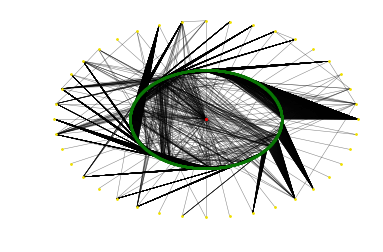

In [76]:
%%time
#nx.draw(main_graph, pos=pos, node_color='pink', edge_color='black', node_size=1)

def draw_graph_waves(graph, pos, nodes_waves, filename):
    for wave, nodes in sorted(nodes_waves.items(), reverse=True):
        nx.draw_networkx_nodes(graph, pos, nodelist=nodes, node_color=colors[wave], node_size=5 - 2 * wave)
    nx.draw_networkx_edges(graph, pos, width=0.5, alpha=0.5)

    plt.axis('off')
    plt.savefig("{}.pdf".format(filename), orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1) 

draw_graph_waves(graph_piece, pos, nodes_waves, 'graph')

## Form dataset from graph nodes

In [17]:
@vk_requester
def get_users(api, api_version, user_ids, fields):
    return api.users.get(user_ids=user_ids, fields=fields, v=api_version)

In [18]:
@request_list
@vk_requester
def get_groups(api, api_version, user_ids, fields):
    return api.groups.get(user_ids=user_ids, extended=1, fields=fields, v=api_version)

In [19]:
features_fields = ['uid', 'first_name', 'last_name', 'deactivated', 
                   'bdate', 'city', 'country', 'home_town', 
                   'universities', 'schools', 'relation', 'counters']
counters = ['audios', 'friends', 'photos', 'videos', 'groups']

features = ['first_name', 'last_name', 'is_active', 'age', 'education', 
            'has_age', 'has_education', 'has_location'] 
features += list(map(lambda x: 'cnt_{}'.format(x), counters)) + ['avg_group_size', 'avg_friend_degree', 'wave', 'degree']

def create_dataset(graph, nodes_data):
    node_ids = list(graph.nodes())
    for node_id in node_ids:
        
        if node_id in nodes_data.index:
            continue
            
        user = get_users(api, api_version, node_id, features_fields)[0]

        f = {feature: np.nan for feature in nodes_data.columns}
        # generate features from acquired fields
        if 'first_name' in user:
            f['first_name'] = user['first_name']

        if 'last_name' in user:
            f['last_name'] = user['last_name']

        if 'deactivated' in user:
            f['is_active'] = 0

        if 'bdate' in user:
            try:
                f['age'] = relativedelta(date.today(), datetime.strptime(user['bdate'], '%d.%m.%Y').date()).years
            except:
                pass
            f['has_age'] = 1
        else:
            f['has_age'] = 0

        if 'universities' in user:
            f['education'] = 'higher'
            f['has_education'] = 1
        elif 'schools' in user:
            f['education'] = 'secondary'
            f['has_education'] = 1
        else:
            f['has_education'] = 0

        if any (field in user for field in ('city', 'country', 'home_town')):
            f['has_location'] = 1
        else:
            f['has_location'] = 0

        if 'counters' in user:
            for counter in counters:
                if counter in user['counters']:
                    f['cnt_{}'.format(counter)] = user['counters'][counter]

        groups = get_groups(api, api_version, node_id, fields=['gid', 'members_count'])
        groups = list(group['members_count'] for group in groups if 'members_count' in group)
        f['avg_group_size'] = sum(groups) / len(groups)

        neighbours_degrees = list(map(lambda x: graph.degree[x], list(graph.neighbors(node_id))))
        f['avg_friend_degree'] = sum(neighbours_degrees) / len(neighbours_degrees)
        
        f['wave'] = [wave for wave, nodes in nodes_waves.items() if node_id in nodes][0]
        
        f['degree'] = graph.degree[node_id]
        
        nodes_data.loc[node_id] = tuple(f[key] for key in features)

In [77]:
nodes_data = pd.DataFrame(columns=features)

In [20]:
nodes_data = pd.read_csv('nodes_data.csv')

In [287]:
%%time
create_dataset(graph_piece, nodes_data)

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 17.8 ms


In [290]:
nodes_data.to_csv('nodes_data.csv')

In [ ]:
%%time
while True:
    try:
        create_dataset(graph_2waves, nodes_data)
        raise MyCoolException()
    except Exception as err:
        if isinstance(err, MyCoolException):
            break

In [21]:
nodes_data.head()

,Unnamed: 0,first_name,last_name,is_active,age,education,has_age,has_education,has_location,cnt_audios,cnt_friends,cnt_photos,cnt_videos,cnt_groups,avg_group_size,avg_friend_degree,wave,degree
0,10938483,Maria,Sindeeva,NaN,20.0,higher,1,1,1,681.0,115.0,284.0,27.0,51.0,58860.173913,38.486957,0.0,115.0
1,280452,Lilya,Kozlova,NaN,NaN,higher,0,1,1,0.0,960.0,60.0,211.0,NaN,58860.173913,2.596234,1.0,956.0
2,5033,Anastasia,Vlasova,NaN,117.0,NaN,1,0,1,0.0,285.0,550.0,58.0,NaN,58860.173913,359.000000,2.0,3.0
3,7523,Lena,Linkova,NaN,117.0,NaN,1,0,1,135.0,659.0,1021.0,26.0,NaN,58860.173913,956.000000,2.0,1.0
4,11797,Anna,Ivanova,NaN,28.0,NaN,1,0,1,172.0,375.0,158.0,11.0,82.0,58860.173913,956.000000,2.0,1.0


## Apply clustering to the data

In [278]:
def spectral_cluster(graph):
    adjacency = nx.adjacency_matrix(graph)
    
    clusterings = []
    for k in range(2, 10):
        cl = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
        clusterings.append(cl)
        
        print('at {} clusters we get {} silhouette'.format(k, silhouette_score(adjacency, cl.labels_)))
    
    best_clustering = max(clusterings, key = lambda clustering: silhouette_score(adjacency, clustering.labels_))
    
    labels_nodes = {label: [] for label in range(best_clustering.n_clusters)}
    for ind, node_id in enumerate(graph.nodes()):
        labels_nodes[best_clustering.labels_[ind]].append(node_id)
        
    return best_clustering, labels_nodes

In [279]:
%%time
clustering, labels_nodes = spectral_cluster(graph_piece)

at 2 clusters we get 0.932726682393105 silhouette
at 3 clusters we get 0.8785709819277412 silhouette
at 4 clusters we get 0.878720072930632 silhouette
at 5 clusters we get 0.8371992914661815 silhouette
at 6 clusters we get 0.7123912687463819 silhouette
at 7 clusters we get 0.7124897434218614 silhouette
at 8 clusters we get 0.7126916910209763 silhouette
at 9 clusters we get 0.7126098587897507 silhouette
CPU times: user 13.8 s, sys: 13.8 s, total: 27.6 s
Wall time: 11.4 s


In [275]:
clustering.n_clusters

2

In [291]:
{label: len(nodes) for label, nodes in labels_nodes.items()}

{0: 3688, 1: 1}

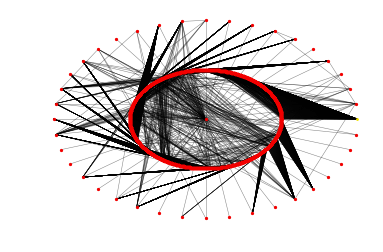

In [292]:
draw_graph_waves(graph_piece, pos, labels_nodes, 'graph_3')

In [ ]:
%%time
#adjacency = smth
    
'''
silhouettes = {}
for k in range(2, 10):
    fit_clustering = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    silhouettes[k] = (silhouette(k, adjacency, fit_clustering.labels_), fit_clustering)
'''

clusterings = []
for k in range(2, 10):
    cl = SpectralClustering(n_clusters=k, affinity='precomputed').fit(adjacency)
    clusterings.append(cl)
    
    labels_nodes = {}
    for label in cl.labels_:
        labels_nodes[label] = [node_id for ind, node_id in enumerate(main_graph.nodes()) if cl.labels_[ind] == label]
    
    
print(max(clusterings, key = lambda clustering: silhouette_score(adjacency, clustering.labels_)))

## Deprecated but possibly useful functions

In [29]:
'''
DEPRECATED IN FAVOUR OF DECORATORS
'''
def get_friends_with_sleep(user_id):
    global requests_count
    if requests_count == 3: # avoid making too many requests
        requests_count = 0
        time.sleep(1)

    try:
        friends = api.friends.get(user_id=user_id, v=api_version)
        requests_count += 1
    except vk.exceptions.VkAPIError as err:
        if err.code in (6, 10): # too many requests per second or internal server error
            time.sleep(1)
            friends = get_friends_with_sleep(user_id)
        else:
            raise err
    if isinstance(friends, list):
        return friends
    return friends['items']

In [36]:
'''
DEPRECATED
'''

def silhouette(k_clusters, data, labels):
    
    s = []
    for vec_ind, vec in enumerate(data):
        vec_cluster = labels[vec_ind]
        b_i = []
        a_i = 0
        for cl_num in range(k_clusters):
            metric = np.average([norm(vec - cl_vec) for cl_vec_ind, cl_vec in enumerate(data) if labels[cl_vec_ind] == cl_num])
            if vec_cluster == cl_num:
                a_i = metric
            else:
                b_i.append(metric)
        b_i = min(b_i)
        
        s_i = (b_i - a_i) / max(a_i, b_i)
        s.append(s_i)
    
    return np.average(s)